In [1]:
# Set paths
idmap_train_dir = '../../data/input/trainmap.csv'
methy_train_dir = '../../data/input/traindata.csv'
idmap_test_dir = '../../data/input/testmap.csv'
methy_test_dir = '../../data/input/testdata.csv'
indices_levine_dir = '../../data/output/indices_list.pkl'
indices_hovarth_dir = '../../data/output/indices_list_horvath.pkl'
indices_train_dir = '../../data/output/all_train_indices.pkl'
indices_test_dir = '../../data/output/all_test_indices.pkl'
output_dir = "../data/output/"

In [2]:
import pandas as pd
import h5py

# Save data as HDF5 files
def save_file_h5(methy_dir, chunk_size, name):
    df_chunks = pd.read_csv(methy_dir,
                            sep=',',
                            index_col=0,
                            chunksize=chunk_size)

    with h5py.File(name, 'w') as file:
        total_cols = 0
        for i, chunk in enumerate(df_chunks):
            chunk = chunk.transpose()
            chunk = chunk.fillna(0)
            data_array = chunk.to_numpy()
            chunk_cols = data_array.shape[1]
            if i == 0:
                samples_num = data_array.shape[0]
                dataset = file.create_dataset('data',
                                              shape=data_array.shape,
                                              maxshape=(samples_num, None))

            dataset.resize((dataset.shape[0], total_cols + chunk_cols))
            dataset[:, total_cols:total_cols + chunk_cols] = data_array
            total_cols += chunk_cols

    return None

In [3]:
create_h5 = False

# Save data
if create_h5:
    chunk_size = 5000

    save_file_h5(methy_train_dir, chunk_size, output_dir + 'train.h5')
    print('Train data saved.')

    save_file_h5(methy_test_dir, chunk_size, output_dir + 'test.h5')
    print('Test data saved.')

In [4]:
import numpy as np

# Load idmap data from .csv file
def load_idmap_csv(file):
    disease_mapping = {
        'control': 0,
        "Alzheimer's disease": 1,
        "Graves' disease": 2,
        "Huntington's disease": 3,
        "Parkinson's disease": 4,
        'rheumatoid arthritis': 5,
        'schizophrenia': 6,
        "Sjogren's syndrome": 7,
        'stroke': 8,
        'type 2 diabetes': 9
    }
    
    idmap = pd.read_csv(file, sep=',')
    age = idmap.age.to_numpy()
    age = age.astype(np.float32)
    disease_type = idmap.disease.replace(disease_mapping)
    
    return age, disease_type

# Load methylation data from .h5 file.
def load_methylation_h5(file, rows=None, extra=None):
    with h5py.File(file, 'r') as h5file:
        methylation = h5file['data'][:]
    
    if rows is not None:
        if isinstance(rows, int):
            methylation = methylation[:, :rows]
        elif isinstance(rows, list):
            if extra is not None:
                extra_data = methylation[:, :extra]
                specific_data = methylation[:, rows]
                methylation = np.hstack((extra_data, specific_data))
            else:
                methylation = methylation[:, rows]
        else:
            return methylation[:, :]
        
    return methylation

In [5]:
import pickle

# Load idmap
age, disease_type = load_idmap_csv(idmap_train_dir)
print("ID map loaded.")

with open(indices_train_dir, 'rb') as indices_train_file:
    indices_train = pickle.load(indices_train_file)

with open(indices_test_dir, 'rb') as indices_test_file:
    indices_test = pickle.load(indices_test_file)

age_train = age[np.array(indices_train)]
age_test = age[np.array(indices_test)]

print("age_train shape:", age_train.shape)
print("age_test shape:",age_test.shape)

disease_train = disease_type[np.array(indices_train)]
disease_test = disease_type[np.array(indices_test)]

print("disease_train shape:", disease_train.shape)
print("disease_test shape:", disease_test.shape)

# Load methylation data
# with open(indices_levine_dir, 'rb') as indices_levine_file:
#     indices_levine = pickle.load(indices_levine_file)

with open(indices_hovarth_dir, 'rb') as indices_hovarth_file:
    indices_hovarth = pickle.load(indices_hovarth_file)

# optimal_indices = indices_levine + indices_hovarth
# optimal_indices = sorted(set(optimal_indices))

methylation_data = load_methylation_h5('../../data/input/train.h5', rows=indices_hovarth)
print("\nMethylation data loaded.")

ID map loaded.
age_train shape: (6994,)
age_test shape: (1239,)
disease_train shape: (6994,)
disease_test shape: (1239,)

Methylation data loaded.


In [6]:
methylation_train = methylation_data[np.array(indices_train)]
methylation_test = methylation_data[np.array(indices_test)]

age_train_reshaped = age_train[:, np.newaxis]  # or age_train.reshape(-1, 1)
age_test_reshaped = age_test[:, np.newaxis]    # or age_test.reshape(-1, 1)

# Concatenate the reshaped arrays with methylation_train and methylation_test
train_data = np.hstack((methylation_train, age_train_reshaped))
test_data = np.hstack((methylation_test, age_test_reshaped))

# Now train_data and test_data should have the desired shapes
print("train_data shape:", train_data.shape)
print("test_data shape:", test_data.shape)

train_data shape: (6994, 354)
test_data shape: (1239, 354)


In [7]:
from sklearn.model_selection import train_test_split
import random

random.seed(42)

# Split data into training and validation sets
indices = np.arange(disease_train.shape[0])
[indices_train, indices_valid, disease_train, disease_valid] = train_test_split(indices, disease_train, test_size=0.15, shuffle=True)

methylation_train = train_data[indices_train]
methylation_valid = train_data[indices_valid]

feature_size = methylation_train.shape[1]


/Users/sharanyapathakota/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [131]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Create deep neural network
model = models.Sequential()
model.add(layers.Dense(354, activation='relu', input_shape=(354,)))
model.add(layers.Dense(300, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Visualize the model architecture
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(methylation_train, disease_train, epochs=100, batch_size=32, 
                    validation_data=(methylation_valid, disease_valid), callbacks=[early_stopping])

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_110 (Dense)           (None, 354)               125670    
                                                                 
 dense_111 (Dense)           (None, 300)               106500    
                                                                 
 dense_112 (Dense)           (None, 64)                19264     
                                                                 
 dense_113 (Dense)           (None, 10)                650       
                                                                 
Total params: 252084 (984.70 KB)
Trainable params: 252084 (984.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
186/186 [==============================] - 1s 4ms/step - loss: 0.8348 - accuracy: 0.7502 - val_loss: 0.6835 - val_accuracy: 0.7552
Ep

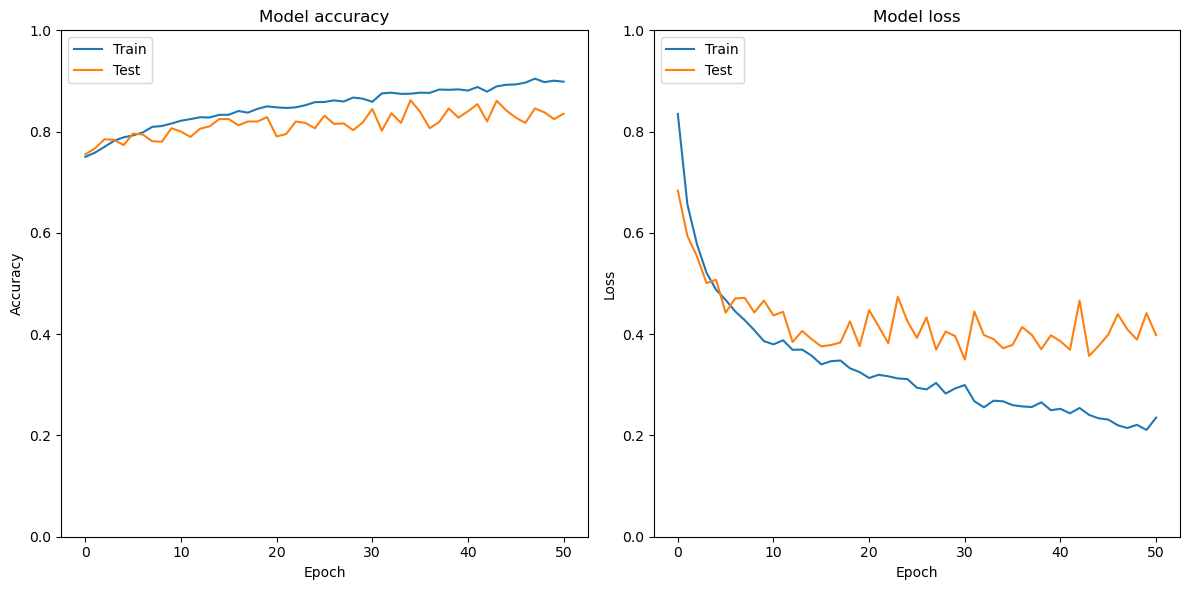

In [133]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim(0, 1)  # Set Y-axis limits from 0 to 1

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim(0, 1)  # Set Y-axis limits from 0 to 1

plt.tight_layout()
plt.show()


In [134]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data, disease_test)

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

39/39 [==============================] - 0s 1ms/step - loss: 0.3769 - accuracy: 0.8321
Test Accuracy: 83.21%


In [123]:
import numpy as np
import pandas as pd

# Reverse mapping for decoding
disease_mapping = {
    'control': 0,
    "Alzheimer's disease": 1,
    "Graves' disease": 2,
    "Huntington's disease": 3,
    "Parkinson's disease": 4,
    'rheumatoid arthritis': 5,
    'schizophrenia': 6,
    "Sjogren's syndrome": 7,
    'stroke': 8,
    'type 2 diabetes': 9
}

reverse_disease_mapping = {v: k for k, v in disease_mapping.items()}

def print_random_decoded_predictions(model, test_data, disease_test, num_samples=10):
    # Make predictions
    predictions = model.predict(test_data)
    predicted_labels = np.argmax(predictions, axis=1)

    # Choose n random samples
    random_indices = np.random.choice(len(test_data), size=num_samples, replace=False)

    # Print decoded predicted values vs actual values for the randomly chosen samples
    print("Sample\tPredicted\t\tActual")
    print("------\t----------\t\t------")

    # Convert disease_test to a numpy array if it's a pandas Series
    if isinstance(disease_test, pd.Series):
        disease_test = disease_test.to_numpy()

    for i, index in enumerate(random_indices):
        decoded_predicted = reverse_disease_mapping[predicted_labels[index]]
        decoded_actual = reverse_disease_mapping[disease_test[index]]
        print(f"{i+1}\t{decoded_predicted.ljust(20)}\t{decoded_actual}")

# Example usage
print_random_decoded_predictions(model, test_data, disease_test, num_samples=20)


39/39 [==============================] - 0s 1ms/step
Sample	Predicted		Actual
------	----------		------
1	control             	control
2	Alzheimer's disease 	control
3	schizophrenia       	schizophrenia
4	control             	control
5	Alzheimer's disease 	control
6	Alzheimer's disease 	Alzheimer's disease
7	control             	control
8	control             	control
9	control             	control
10	Alzheimer's disease 	Alzheimer's disease
11	control             	control
12	control             	control
13	Huntington's disease	Huntington's disease
14	Graves' disease     	Graves' disease
15	control             	control
16	Alzheimer's disease 	Alzheimer's disease
17	rheumatoid arthritis	rheumatoid arthritis
18	control             	control
19	control             	control
20	rheumatoid arthritis	rheumatoid arthritis
